# mixed coordinate cutting plane examples

using a 3d spherical, yt sample dataset (KeplerianDisk)

yt : [INFO     ] 2024-02-28 11:24:15,960 Sample dataset found in '/Users/chavlin/data/yt_data/KeplerianDisk/disk.out1.00000.athdf'
yt : [WARNING  ] 2024-02-28 11:24:15,983 Assuming 1.0 = 1.0 cm
yt : [WARNING  ] 2024-02-28 11:24:15,984 Assuming 1.0 = 1.0 s
yt : [WARNING  ] 2024-02-28 11:24:15,984 Assuming 1.0 = 1.0 g
yt : [WARNING  ] 2024-02-28 11:24:15,985 Assuming 1.0 = 1.0 K
yt : [INFO     ] 2024-02-28 11:24:16,008 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-28 11:24:16,008 Parameters: domain_dimensions         = [256  64   4]
yt : [INFO     ] 2024-02-28 11:24:16,009 Parameters: domain_left_edge          = [0.3        1.17809725 0.        ]
yt : [INFO     ] 2024-02-28 11:24:16,009 Parameters: domain_right_edge         = [3.         1.96349541 6.28318531]
yt : [INFO     ] 2024-02-28 11:24:16,010 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-02-28 11:24:16,012 Making a fixed resolution buffer of (('athena_pp', 'dens')) 800 by 800


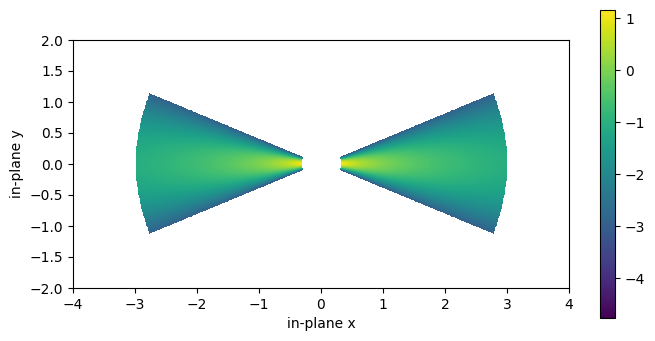

In [134]:
import yt
import numpy as np
import matplotlib.pyplot as plt 

# load a dataset in 3d spherical coordinates
ds = yt.load_sample("KeplerianDisk")

# define a cartesian plane (in cartesian coordinates)
# the following plane will be the x-z plane
normal = np.array([0.0, 1.0, 0.0])
plane_center = np.array([0.0, 0.0, 0.0])
slc = ds.cutting_mixed(normal, plane_center)

# extract a frb, width and height here are 
# in-plane cartesian distances measured from the 
# plane_center
frb = slc.to_frb(8.0, 800, height=4.0)
bvals = frb[("athena_pp", "dens")]

# mask out empty values for plotting
mask = frb.get_mask(("athena_pp", "dens"))
bvals[~mask] = np.nan

# plot it
f = plt.figure(figsize=(8,4))
plt.imshow(np.log10(bvals), extent=frb.bounds, origin='lower')
plt.xlabel("in-plane x")
plt.ylabel("in-plane y")
plt.colorbar()

## Some examples with seismic models


### small regional model

uniform grid, seismic velocity model, http://ds.iris.edu/ds/products/emc-hawaiianr22/ without topography (direct data link: http://ds.iris.edu/files/products/emc/emc-files/HawaiiANR22-withouttopo.r0.0.nc). 

technically in geodetic coordinates so need to convert to spherical first (since this PR only implements the behavior for spherical coordinates at present). 

/var/folders/10/_8drrwm95vvf335f36p3r4yc0000gp/T/ipykernel_23293/2218766073.py:26: RuntimeWarning: Mean of empty slice
  dvs_z = np.nanmean(np.nanmean(Vs, axis=1), axis=1)
yt : [INFO     ] 2024-02-28 11:40:33,474 Parameters: current_time              = 0.0
yt : [INFO     ] 2024-02-28 11:40:33,475 Parameters: domain_dimensions         = [400  81  76]
yt : [INFO     ] 2024-02-28 11:40:33,475 Parameters: domain_left_edge          = [6.35105000e+03 3.27947353e-01 3.55680654e+00]
yt : [INFO     ] 2024-02-28 11:40:33,475 Parameters: domain_right_edge         = [6.37095000e+03 3.56221694e-01 3.58333554e+00]
yt : [INFO     ] 2024-02-28 11:40:33,476 Parameters: cosmological_simulation   = 0
yt : [INFO     ] 2024-02-28 11:40:33,477 Making a fixed resolution buffer of (dvs) 1000 by 1000


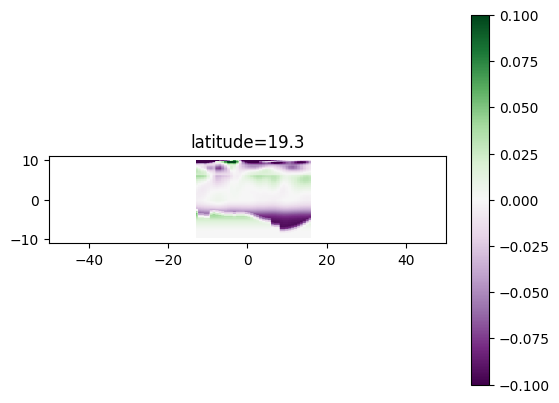

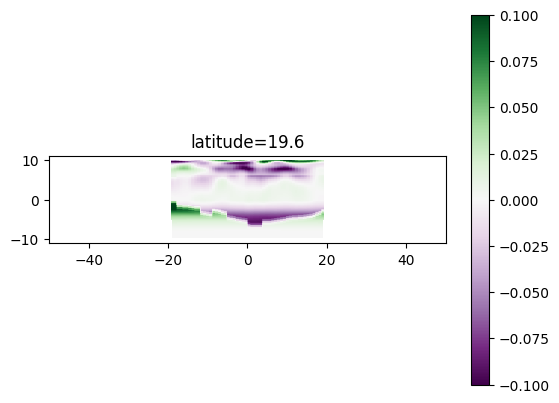

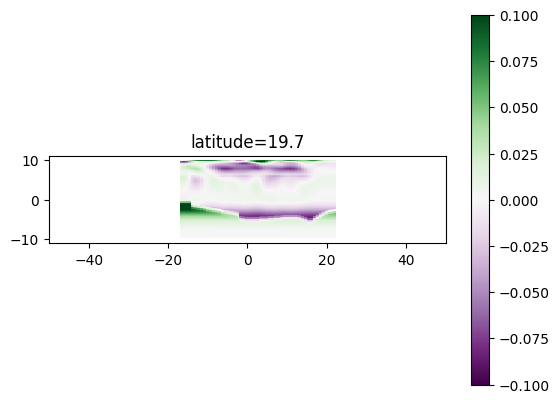

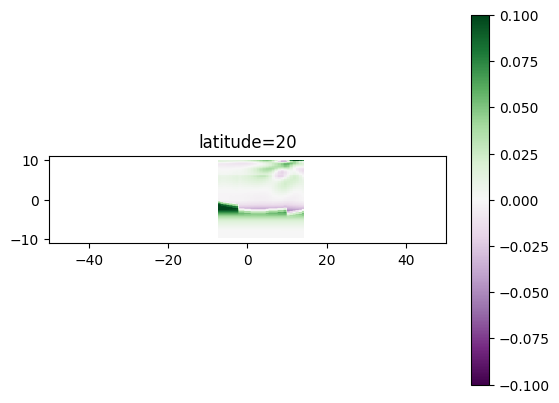

In [149]:
import xarray 
import os
from yt.utilities.lib.coordinate_utilities import spherical_points_to_cartesian

# load in data into yt
fi = os.path.join(yt.config.ytcfg.get('yt', 'test_data_dir'),
                  "earthscope_emc",
                  "HawaiiANR22-withouttopo.r0.0.nc")
ds_x = xarray.open_dataset(fi)
ddepth = 0.05 
dlon = 0.02 
dlat = 0.02 
R = 6371.
r_range = [R - (ds_x.depth.max()-ddepth/2), R - (ds_x.depth.min()+ddepth/2)]
lat_range = [ds_x.latitude.min()-dlon/2, ds_x.latitude.max()+dlon/2]
lon_range = [360.+ds_x.longitude.min()-dlon/2, 360.+ds_x.longitude.max()+dlon/2]

bbox = np.array([r_range, 
                 lat_range, 
                 lon_range]).astype('float64')
bbox[1:,:] = bbox[1:,:] * np.pi/180. 

Vs = np.flipud(ds_x.Vs.values.astype('float64')) # might need reshape

# calculate a diff from horizontal mean
dvs_z = np.nanmean(np.nanmean(Vs, axis=1), axis=1)
dvs_z = np.repeat(dvs_z[:,np.newaxis], Vs.shape[1], axis=1)
dvs_z = np.repeat(dvs_z[:,:, np.newaxis], Vs.shape[2], axis=2)
dvs_z = (Vs - dvs_z)/dvs_z

ds = yt.load_uniform_grid({'vs': Vs, 'dvs': dvs_z,}, 
                          Vs.shape, 
                          bbox=bbox, 
                          length_unit='km', 
                          geometry='spherical', 
                          axis_order=('r', 'theta', 'phi'))

# define a cutting plane by selecting two points and constructing a normal
# at a line of fixed latitude 

pts = np.zeros((3,3))
pts[0,:] = r_range[1]
pts[0,2] = ds.domain_center[0].d
pts[2,0] = ds.domain_left_edge[2].d
pts[2,1] = ds.domain_right_edge[2].d
pts[2,2] = ds.domain_center[2].d

for latval in (19.3, 19.6, 19.7, 20):
    pts[1,:] = latval * np.pi/180 
    x, y, z = spherical_points_to_cartesian(pts[0,:], pts[1,:], pts[2,:])
    normal = np.cross((x[0], y[0], z[0]), (x[1], y[1], z[1]) )
    center = np.array([x[2], y[2], z[2]])
    north_vector = center
    
    slc = ds.cutting_mixed(normal, center, north_vector=north_vector)
    frb = slc.to_frb(100, 1000, height=22)
    vs_frb = frb['dvs']
    vs_frb[~frb.get_mask('dvs')] = np.nan
    plt.imshow(vs_frb, extent=frb.bounds, origin='lower', cmap='PRGn', clim=(-.1, .1))
    plt.colorbar()
    plt.title(f"latitude={latval}")
    plt.show()

In [151]:
lon_range

[<xarray.DataArray 'longitude' ()>
 array(203.79000305),
 <xarray.DataArray 'longitude' ()>
 array(205.31000305)]